# Final Project: Facial Expression Recognition
#### By Shivani Bhakta and Payal Singh 

In [1]:
# imports
import numpy as np
import glob
from PIL import Image
from PIL import Image, ImageOps
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

from facenet_pytorch import MTCNN

from torch.utils.data import Dataset
import os
import os.path as osp
import cv2 
import sys

from woodnet import *

In [2]:
import torch
import copy

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Tufts Face DB 
In this project we use a dataset named Tufts Face Database for Facial Recognition. This dataset is made up with over 10,000 images of 74 female and 38 males from more than 15 countried with the age range between 4-70 years old. This dataset contains 7 image modalities, but we only use a subset of it, from the Tufts Face Databse 2D RGB Around (TDRGBA).


In this project we use few pictures for each person to train the model and the rest to predict which person's picture it is. There are total of 50 people, whose pictures we are going to use. 

## Visualize the dataset
#### Reduce the size of the dataset to 10x smaller and store the new images into dataset/resized

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import PI

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))
for person in range(1, 51): 
    if person == 47: continue
    for idx in range(1,6):
        t = 'dataset/' + str(person) + '/TD_RGB_E_{}.jpg'.format(idx)

        im = Image.open(t)
        width, height = im.size #3072,4608

        newsize = (width//10, height//10)
        im2 = im.resize(newsize) # resized Image Size:  (460, 307)
    
        fn = 'TD_RGB_E_{}_{}.jpg'.format(person,idx)
        im2.save('dataset/resized/' + fn)
    
        if person == 1: 
            # Display the first person's all images
            if idx in [1,2]: 
                i = 0
                j = idx - 1

            elif idx in [3,4]:
                i = 1
                j = idx - 3    
            else: 
                i = 2
                j = idx - 5 
            axes[i][j].axis('off')
            axes[i][j].imshow(im2)
            axes[i][j].set_title('Person 1 , image {}'.format(idx))
#             print("resized Image Size: ", im2.size)

# Dataloader

In [3]:
def get_faces():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point(each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point(each image of smiling faces)
    '''

    n = 49    # will change when do data augmentation
#     neutral_faces = np.zeros((n,224,224,3))
#     smiling_faces = np.zeros((n,224,224,3))
#     eyesclosed_faces = np.zeros((n,224,224,3))
#     surprised_faces = np.zeros((n,224,224,3))
#     sunglasses_faces = np.zeros((n,224,224,3))

    neutral_faces = np.zeros((n,3,224,224))
    smiling_faces = np.zeros((n,3,224,224))
    eyesclosed_faces = np.zeros((n,3,224,224))
    surprised_faces = np.zeros((n,3,224,224))
    sunglasses_faces = np.zeros((n,3,224,224))

    for i in range(1,n+1):
        if i == 47: continue     
        path = str('cropped/')
            
        for j in range(1,6):
            image_path = path + 'TD_RGB_E_{}_{}.jpg'.format(i,j)
            p = Image.open(image_path)        
#             size = p.size
#             p = ImageOps.grayscale(p)
            p = np.transpose(np.array(p))
#             print(np.transpose(p).shape)
            
            if j == 1: neutral_faces[i-1,:] = p
            elif j == 2: smiling_faces[i-1,:] = p
            elif j ==3: eyesclosed_faces[i-1,:] = p
            elif j == 4: surprised_faces[i-1,:] = p
            elif j == 5: sunglasses_faces[i-1,:] = p

#     return np.transpose(neutral_faces), np.transpose(smiling_faces), np.transpose(eyesclosed_faces), np.transpose(surprised_faces), np.transpose(sunglasses_faces)
    return neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces()
print(neutral_faces.shape)

(49, 3, 224, 224)


In [4]:
# dataset

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces()


data = np.vstack((neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces))
labels_0 = [0] * len(neutral_faces)
labels_1 = [1] * len(neutral_faces)
labels_2 = [2] * len(neutral_faces)
labels_3 = [3] * len(neutral_faces)
labels_4 = [4] * len(neutral_faces)

labels = labels_0 + labels_1 + labels_2 + labels_3 + labels_4
labels = np.array(labels)
idxs = list(range(245))   # will change when do data augmentation
np.random.shuffle(idxs)

data = data[idxs]
labels = labels[idxs]

print(type(data))
print(data.shape)

test_train_split = 0.88889
train_data = data[:int(test_train_split * len(idxs))]
train_labels = labels[:int(test_train_split * len(idxs))]

print(type(train_data))
print(train_data.shape)

test_data = data[int(test_train_split * len(idxs)):]
test_labels = labels[int(test_train_split * len(idxs)):]

# train_data = torch.tensor(train_data)
# train_labels = torch.tensor(train_labels)
# train_data = TensorDataset(train_data, train_labels)

# test_data = torch.tensor(test_data)
# test_labels = torch.tensor(test_labels)
# test_data = TensorDataset(test_data, test_labels)

<class 'numpy.ndarray'>
(245, 3, 224, 224)
<class 'numpy.ndarray'>
(217, 3, 224, 224)


(49, 3, 224, 224)


IndexError: index 25 is out of bounds for axis 1 with size 3

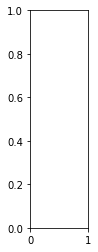

In [24]:
def test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, n): 
# def test(neutral_faces,smiling_faces,eyesclosed_faces, n): 
    '''
    Function to test that I am able to recontruct the original image with after all the reshaping and shaping.
    Checking the dimensions and shape as well. 
    '''
    print(neutral_faces.shape)

    plt.subplot(1,5,1)
    plt.imshow((neutral_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,2)
    plt.imshow((smiling_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,3)
    plt.imshow((eyesclosed_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,4)
    plt.imshow((surprised_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,5)
    plt.imshow((sunglasses_faces[:,n]).reshape((224,224)))

    # Executing test function        
test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, 25)  

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
#         print(x)
        data = {'x': x, 'y': y}
        return data
    
    def __len__(self):
        return len(self.data)

train_data = MyDataset(train_data, train_labels)
# dataloader = DataLoader(dataset, batch_size=5)

In [ ]:
# http://vision.ucsd.edu/content/yale-face-database
images = []


for f in glob.iglob('Tufts/Set1/1/*'):
    images.append(np.asarray(Image.open(f)))
#     print(f)
#     break
    
images = np.array(images)
print(images.shape)

In [ ]:
# http://vision.ucsd.edu/content/yale-face-database
images = []

for i in range(1,3): 
    for f in glob.iglob('Tufts/Set1/'+  str(i) + '/*'):
        images.append(np.asarray(Image.open(f)))
#         print(f)
#         break


print(images.shape)
# images = np.array(images)

In [ ]:
# print(images[0,:,:,:])
# im1 = Image.open('Tufts/Set1/25/TD_RGB_A_4_6.jpg')
plt.imshow(images[,:,:,:], cmap='gray')

In [ ]:
# im1 = Image.open('yalefaces/subject12.glasses')
im1 = Image.open('Tufts/Set1/25/TD_RGB_A_4_6.jpg')
plt.imshow(np.array(im1), cmap='gray')

In [ ]:
im1 = Image.open('Tufts/Set1/25/TD_RGB_A_4_7.jpg')
plt.imshow(np.array(im1), cmap='gray')

In [ ]:
im1 = Image.open('Tufts/Set1/25/TD_RGB_A_4_8.jpg')
plt.imshow(np.array(im1), cmap='gray')

In [ ]:
# split into train and test
# train: centerlight, glasses, happy, leftlight, noglasses, normal, rightlight, sad
# test: sleepy, surprised, and wink

train_imgs = ['centerlight', 'glasses', 'happy', 'leftlight', 'noglasses', 'normal', 'rightlight', 'sad']
test_imgs = ['sleepy', 'surprised', 'wink']

train_data = []
test_data = []

images = []
for f in glob.iglob('yalefaces/*'):
    if f.split(".", 1)[1] in train_imgs:
        train_data.append(np.asarray(Image.open(f)))
    else:
        test_data.append(np.asarray(Image.open(f)))
        
train_data = np.array(train_data)
test_data = np.array(test_data)

In [ ]:
print(train_data.shape)
print(test_data.shape)

5/27 to do next:
- need dataloader
- figure out if data is already centered (if not, how to do it for PCA)
- feature extraction (PCA)
- train our ELMAN RNN (link for how to use RNN with Pytorch: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch, https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- find optimal weights
- test
- try out other types of netral networks

Reference*
Any publication using this database must reference to this: 
- Website: http://tdface.ece.tufts.edu/ and this 
- Paper: Panetta, Karen, Qianwen Wan, Sos Agaian, Srijith Rajeev, Shreyas Kamath, Rahul Rajendran, Shishir Rao et al. "A comprehensive database for benchmarking imaging systems." IEEE Transactions on Pattern Analysis and Machine Intelligence (2018).

In [ ]:
# https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch
mtcnn = MTCNN(image_size=224, margin=20, keep_all=True, post_process=False, device='cuda')

# Load a single image and display
frame = cv2.imread('TD_RGB_E/1/TD_RGB_E_1.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

# Detect face
face = mtcnn(frame)
face.shape

In [ ]:
# face detection code, save cropped face 
# https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch
IMAGE_SIZE = 224

for person in range(1, 51):
    if person == 47: continue
    for idx in range(1, 6):
        # Load a single image and display
        frame = cv2.imread(f'TD_RGB_E/{person}/TD_RGB_E_{idx}.jpg')
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
        frame = Image.fromarray(frame)

        mtcnn(frame, save_path=f'cropped/TD_RGB_E_{person}_{idx}.jpg')

In [ ]:
# data augmentation

In [14]:
NUM_TRAIN = len(train_data)
NUM_TEST = len(test_data)

def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


def train_model(model, optimizer, epochs=1):
    """
    Train a model lol
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model.train()  # put model to training mode
    for e in range(epochs):
        for t, data in enumerate(loader_train):
#             print(data)
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy(loader_val, model)
                print()

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
loader_train = DataLoader(train_data, batch_size=12, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
#                             transform=transform_test)
loader_test = DataLoader(test_data, batch_size=4)

In [15]:
# define neural network
model = WoodNet()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=3)

<class 'torch.Tensor'>


RuntimeError: Given groups=1, weight of size 32 3 3 3, expected input[12, 32, 112, 112] to have 3 channels, but got 32 channels instead

In [ ]:
# test set accuracy
check_accuracy(loader_test, model)